In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from transformers import Wav2Vec2PreTrainedModel, Wav2Vec2Model
import torch.nn.functional as F
from transformers import TrainerCallback, TrainerState, TrainerControl, TrainingArguments, Trainer, AutoModelForAudioClassification
from transformers import DataCollator
from torch.utils.data import DataLoader
from transformers import EvalPrediction
from sklearn.metrics import f1_score
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer, AutoFeatureExtractor
import evaluate
from sklearn.metrics import f1_score
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
df = pd.read_pickle('AnnoMI-wav2vec-new.pkl')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Extract unique class names for client and therapist tasks
client_class_names = df['client_talk_type'].dropna().unique().tolist()
therapist_class_names = df['main_therapist_behaviour'].dropna().unique().tolist()

client_class_names, therapist_class_names

(['neutral', 'change', 'sustain'],
 ['question', 'therapist_input', 'reflection', 'other'])

In [5]:
# make a dataset where intelocutor is client
df_client = df[df['interlocutor'] == 'client']
df_client = df_client[['client_wav2vec_emb', 'client_talk_type']]
df_client.rename(columns={'client_wav2vec_emb': 'embeddings', 'client_talk_type': 'labels'}, inplace=True)
df_client['labels'] = df_client['labels'].astype("category").cat.codes

df_therapist = df[df['interlocutor'] == 'therapist']
df_therapist = df_therapist[['therapist_wav2vec_emb', 'main_therapist_behaviour']]
df_therapist.rename(columns={'therapist_wav2vec_emb': 'embeddings', 'main_therapist_behaviour': 'labels'}, inplace=True)
df_therapist['labels'] = df_therapist['labels'].astype("category").cat.codes

In [6]:
client_train_data, client_test_data = train_test_split(df_client, test_size=0.2, random_state=42)
therapist_train_data, therapist_test_data = train_test_split(df_therapist, test_size=0.2, random_state=42)

In [7]:
client_train_data['inputs'] = client_train_data['embeddings'].apply(lambda x: x['input_values'][0])
client_test_data['inputs'] = client_test_data['embeddings'].apply(lambda x: x['input_values'][0])

therapist_train_data['inputs'] = therapist_train_data['embeddings'].apply(lambda x: x['input_values'][0])
therapist_test_data['inputs'] = therapist_test_data['embeddings'].apply(lambda x: x['input_values'][0])

client_train_data['attention_mask'] = client_train_data['embeddings'].apply(lambda x: x['attention_mask'][0])
client_test_data['attention_mask'] = client_test_data['embeddings'].apply(lambda x: x['attention_mask'][0])

therapist_train_data['attention_mask'] = therapist_train_data['embeddings'].apply(lambda x: x['attention_mask'][0])
therapist_test_data['attention_mask'] = therapist_test_data['embeddings'].apply(lambda x: x['attention_mask'][0])


In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # Determine the maximum sequence length in the dataset
        self.max_len_input = max(dataframe['inputs'].apply(len))
        self.max_len_attention = max(dataframe['attention_mask'].apply(len))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data.iloc[idx]['labels'], dtype=torch.long)
        
        input_values = torch.tensor(self.data.iloc[idx]['inputs'], dtype=torch.float)

        attention_mask = torch.tensor(self.data.iloc[idx]['attention_mask'], dtype=torch.long)
        
        # Calculate the amount of padding required
        padding_size_input = self.max_len_input - len(input_values)
        padding_size_attention = self.max_len_attention - len(attention_mask)
        
        # Pad the input_values using torch.nn.functional.pad
        input_values_padded = F.pad(input_values, (0, padding_size_input), mode='constant', value=0)
        attention_mask_padded = F.pad(attention_mask, (0, padding_size_attention), mode='constant', value=0)
        
        return {
            "input_values": input_values_padded,
            "labels": label,
            "attention_mask": attention_mask_padded
        }

In [9]:
client_train_dataset = CustomDataset(client_train_data)
client_test_dataset = CustomDataset(client_test_data)  

therapist_train_dataset = CustomDataset(therapist_train_data)
therapist_test_dataset = CustomDataset(therapist_test_data)

In [10]:
class MTLWav2Vec(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist):
        super(MTLWav2Vec, self).__init__()

        # Shared layer
        self.base_model = Wav2Vec2Model.from_pretrained(base_model_name)

        # Client specific classifier
        self.client_classifier = nn.Linear(self.base_model.config.hidden_size, num_classes_client)

        # Therapist specific classifier
        self.therapist_classifier = nn.Linear(self.base_model.config.hidden_size, num_classes_therapist)

    def forward(self, input_values, attention_mask, task_name):
        # Passing input_values through the shared layer
        shared_output = self.base_model(input_values=input_values, attention_mask=attention_mask)
        
        # pooled_output = shared_output[0][:, 0, :]
        pooled_output = torch.mean(shared_output[0], dim=1)

        # Routing through the appropriate classifier
        if task_name == 'client':
            return self.client_classifier(pooled_output)
        elif task_name == 'therapist':
            return self.therapist_classifier(pooled_output)
        else:
            raise ValueError(f"Invalid task_name: {task_name}. Expected 'client' or 'therapist'.")

In [11]:
num_classes_client = 3  # ['neutral', 'change', 'sustain']
num_classes_therapist = 4  # ['question', 'therapist_input', 'reflection', 'other']
model = MTLWav2Vec("facebook/wav2vec2-large", num_classes_client, num_classes_therapist).to(device)

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
epochs = 100
batch_size = 32

# Assuming train_dataset_client and train_dataset_therapist are prepared datasets
train_loader_client = DataLoader(client_train_dataset, batch_size=batch_size, shuffle=True)
train_loader_therapist = DataLoader(therapist_train_dataset, batch_size=batch_size, shuffle=True)

val_loader_client = DataLoader(client_test_dataset, batch_size=batch_size, shuffle=False)
val_loader_therapist = DataLoader(therapist_test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
loss_fn = nn.CrossEntropyLoss()

# Lists to store metrics for plotting
training_losses = []
validation_losses = []
training_f1_scores_client = []
validation_f1_scores_client = []
training_f1_scores_therapist = []
validation_f1_scores_therapist = []

# To keep track of the best model based on validation F1 score
best_f1_score_client = 0.0
best_f1_score_therapist = 0.0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    all_train_preds_client = []
    all_train_labels_client = []
    all_train_preds_therapist = []
    all_train_labels_therapist = []

    # Training phase for client task
    train_bar_client = tqdm(train_loader_client, desc=f"Training (Client) Epoch {epoch+1}", position=0, leave=True)
    for batch in train_bar_client:
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_values=input_values, attention_mask=attention_mask, task_name='client')
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_bar_client.set_postfix(train_loss=loss.item())
        preds = torch.argmax(outputs, dim=1).flatten()
        all_train_preds_client.extend(preds.cpu().detach().numpy())
        all_train_labels_client.extend(labels.cpu().detach().numpy())

    train_f1_client = f1_score(all_train_labels_client, all_train_preds_client, average='macro')
    training_f1_scores_client.append(train_f1_client)


    # Training phase for therapist task
    train_bar_therapist = tqdm(train_loader_therapist, desc=f"Training (Therapist) Epoch {epoch+1}", position=0, leave=True)
    for batch in train_bar_therapist:
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_values=input_values, attention_mask=attention_mask, task_name='therapist')
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_bar_therapist.set_postfix(train_loss=loss.item())
        preds = torch.argmax(outputs, dim=1).flatten()
        all_train_preds_therapist.extend(preds.cpu().detach().numpy())
        all_train_labels_therapist.extend(labels.cpu().detach().numpy())

    train_f1_therapist = f1_score(all_train_labels_therapist, all_train_preds_therapist, average='macro')
    training_f1_scores_therapist.append(train_f1_therapist)

    training_losses.append(total_train_loss)

    # Validation phase for client task
    model.eval()
    total_val_loss = 0
    all_val_preds_client = []
    all_val_labels_client = []

    val_bar_client = tqdm(val_loader_client, desc=f"Validation (Client) Epoch {epoch+1}", position=0, leave=True)
    for batch in val_bar_client:
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_values=input_values, attention_mask=attention_mask, task_name='client')
        loss = loss_fn(outputs, labels)
        total_val_loss += loss.item()
        val_bar_client.set_postfix(val_loss=loss.item())
        preds = torch.argmax(outputs, dim=1).flatten()
        all_val_preds_client.extend(preds.cpu().detach().numpy())
        all_val_labels_client.extend(labels.cpu().detach().numpy())

    val_f1_client = f1_score(all_val_labels_client, all_val_preds_client, average='macro')
    validation_f1_scores_client.append(val_f1_client)

    # Evaluation phase for therapist task
    all_val_preds_therapist = []
    all_val_labels_therapist = []

    val_bar_therapist = tqdm(val_loader_therapist, desc=f"Evaluating (Therapist) Epoch {epoch+1}", position=0, leave=True)
    with torch.no_grad():
        for batch in val_bar_therapist:
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_values=input_values, attention_mask=attention_mask, task_name='therapist')
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()
            val_bar_therapist.set_postfix(val_loss=loss.item())
            preds = torch.argmax(outputs, dim=1).flatten()
            all_val_preds_therapist.extend(preds.cpu().detach().numpy())
            all_val_labels_therapist.extend(labels.cpu().detach().numpy())

    val_f1_therapist = f1_score(all_val_labels_therapist, all_val_preds_therapist, average='macro')
    validation_f1_scores_therapist.append(val_f1_therapist)

    validation_losses.append(total_val_loss)

    # Save the best model based on validation F1 score
    if val_f1_client > best_f1_score_client and val_f1_therapist > best_f1_score_therapist:
        best_f1_score_client = val_f1_client
        best_f1_score_therapist = val_f1_therapist
        torch.save(model.state_dict(), "best_mtl_model_audio_wav2vec_client.pth")
        torch.save(model.state_dict(), "best_mtl_model_audio_wav2vec_therapist.pth")
    elif val_f1_client > best_f1_score_client:
        best_f1_score_client = val_f1_client
        torch.save(model.state_dict(), "best_mtl_model_audio_wav2vec_client.pth")
    elif val_f1_therapist > best_f1_score_therapist:
        best_f1_score_therapist = val_f1_therapist
        torch.save(model.state_dict(), "best_mtl_model_audio_wav2vec_therapist.pth")


    print(f"Epoch {epoch+1}, Train Loss: {total_train_loss}, Val Loss: {total_val_loss}, \nTrain F1 Client: {train_f1_client:.4f}, Val F1 Client: {val_f1_client:.4f}, \nTrain F1 Therapist: {train_f1_therapist:.4f}, Val F1 Therapist: {val_f1_therapist:.4f}")


Training (Client) Epoch 1:   0%|          | 0/159 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 116.97 GiB (GPU 0; 39.59 GiB total capacity; 4.60 GiB already allocated; 34.50 GiB free; 4.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

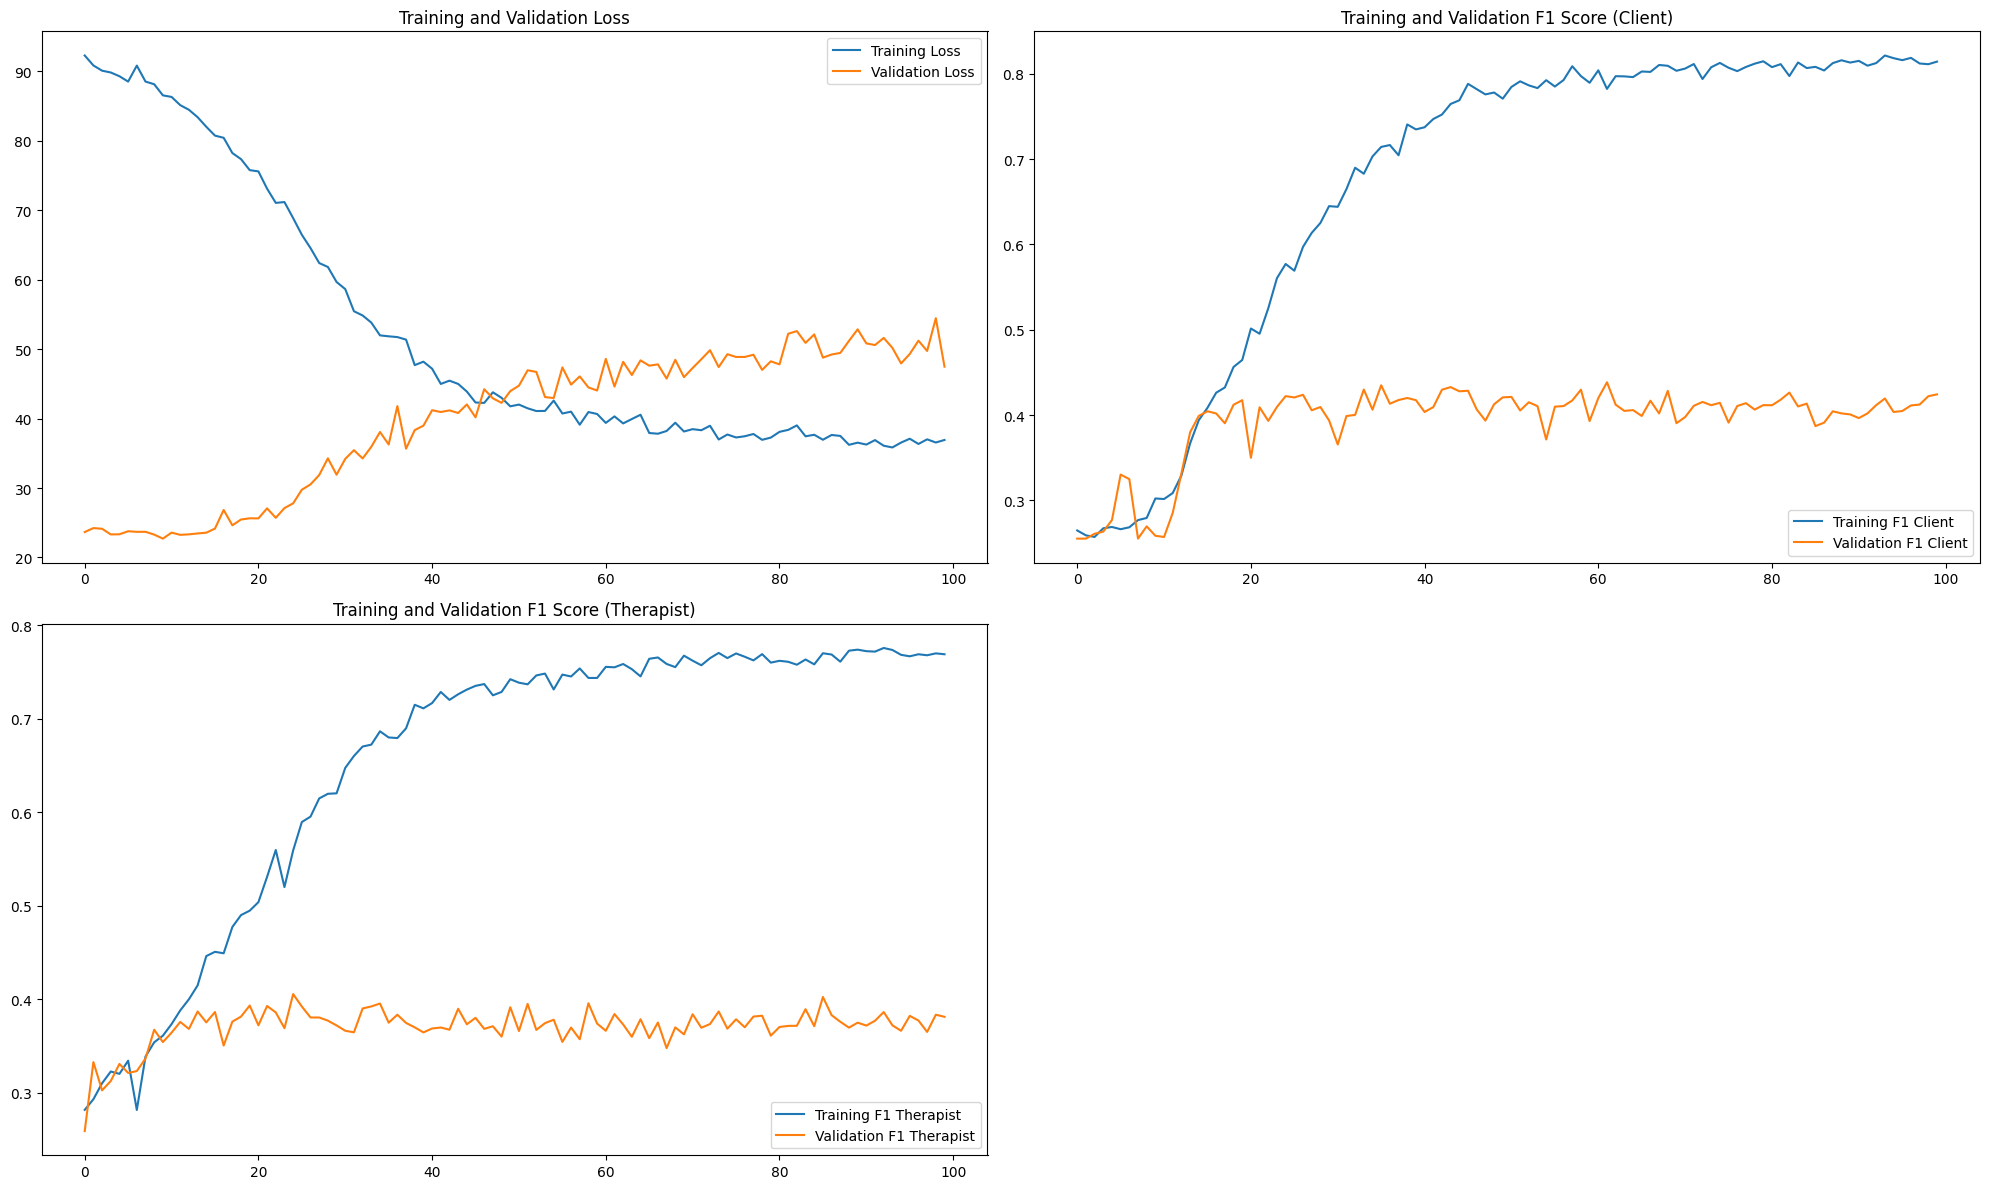

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(20, 12))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plot training and validation F1 scores for Client
plt.subplot(2, 2, 2)
plt.plot(epochs_range, training_f1_scores_client, label='Training F1 Client')
plt.plot(epochs_range, validation_f1_scores_client, label='Validation F1 Client')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Client)')

# Plot training and validation F1 scores for Therapist
plt.subplot(2, 2, 3)
plt.plot(epochs_range, training_f1_scores_therapist, label='Training F1 Therapist')
plt.plot(epochs_range, validation_f1_scores_therapist, label='Validation F1 Therapist')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Therapist)')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model
model_client = model
model_client.load_state_dict(torch.load("best_mtl_model_audio_wav2vec_client.pth"))
model_client.eval()

model_therapist = model
model_therapist.load_state_dict(torch.load("best_mtl_model_audio_wav2vec_therapist.pth"))
model_therapist.eval()

# Final evaluation function
def evaluate_model(model, dataloader, task_name):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch['input_values'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, task_name=task_name)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate for both tasks
labels_client, preds_client = evaluate_model(model_client, val_loader_client, "client")
labels_therapist, preds_therapist = evaluate_model(model_therapist, val_loader_therapist, "therapist")

# For client task:
print("\nFinal Classification Report (Client):")
print(classification_report(labels_client, preds_client, target_names=client_class_names))

# For therapist task:
print("\nFinal Classification Report (Therapist):")
print(classification_report(labels_therapist, preds_therapist, target_names=therapist_class_names))



Final Classification Report (Client):
              precision    recall  f1-score   support

     neutral       0.38      0.42      0.40       332
      change       0.69      0.68      0.68       786
     sustain       0.20      0.17      0.18       150

    accuracy                           0.55      1268
   macro avg       0.42      0.42      0.42      1268
weighted avg       0.55      0.55      0.55      1268


Final Classification Report (Therapist):
                 precision    recall  f1-score   support

       question       0.49      0.77      0.60       455
therapist_input       0.53      0.29      0.37       364
     reflection       0.39      0.38      0.39       282
          other       0.39      0.20      0.26       187

       accuracy                           0.47      1288
      macro avg       0.45      0.41      0.41      1288
   weighted avg       0.46      0.47      0.44      1288

